## TRASNFER LEARNING: INITIAL TEST

### Introduction

### Libraries

In [5]:
#basic
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#tensorflow and keras
from tensorflow import keras
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Model
from keras_preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50

#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Functions

In [6]:
from utils import transform_diagnosis_to_numerical, add_prefix_to_string, predict_image, probability_to_categorical, plot_confusion_matrix

### Globals

In [7]:
RANDOM_SEED = 42
EPOCHS = 100

### Reading data 

In [9]:
dataframe = pd.read_csv("../../../../data/metadata.csv")
image_file_names_and_diagnosis = dataframe[["img_id", "diagnostic"]]

### Data transformations

In [10]:
image_file_names_and_diagnosis["img_id"] = image_file_names_and_diagnosis["img_id"].apply(
    lambda string: add_prefix_to_string(string, "../../../../data/images/all_images/"))

/tmp/ipykernel_5468/3534156525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_file_names_and_diagnosis["img_id"] = image_file_names_and_diagnosis["img_id"].apply(


In [11]:
image_file_names_and_diagnosis.head()

,img_id,diagnostic
0,../../../../data/images/all_images/PAT_1516_17...,NEV
1,../../../../data/images/all_images/PAT_46_881_...,BCC
2,../../../../data/images/all_images/PAT_1545_18...,ACK
3,../../../../data/images/all_images/PAT_1989_40...,ACK
4,../../../../data/images/all_images/PAT_684_130...,BCC


In [12]:
image_file_names_and_diagnosis.img_id[0]

'../../../../data/images/all_images/PAT_1516_1765_530.png'

### Split data in train, test and validation

In [13]:
stratified_shuffle_split_train_test = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)
stratified_shuffle_split_train_val = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.1,
    random_state=RANDOM_SEED,
)

In [14]:
for train_index, test_index in stratified_shuffle_split_train_test.split(
    image_file_names_and_diagnosis,
    image_file_names_and_diagnosis["diagnostic"]):
        stratified_train_and_validation_set = image_file_names_and_diagnosis.iloc[train_index]
        stratified_test_set = image_file_names_and_diagnosis.iloc[test_index]

In [15]:
for train_index, validation_index in stratified_shuffle_split_train_val.split(
    stratified_train_and_validation_set,
    stratified_train_and_validation_set["diagnostic"]):
        stratified_train_set = stratified_train_and_validation_set.iloc[train_index]
        stratified_validation_set = stratified_train_and_validation_set.iloc[validation_index]

In [16]:
stratified_train_set = stratified_train_set.reset_index()
stratified_validation_set = stratified_validation_set.reset_index()
stratified_test_set = stratified_test_set.reset_index()

In [17]:
print("Examples in train set: {0}".format(stratified_train_set.shape[0]))
print("Examples in validation set: {0}".format(stratified_validation_set.shape[0]))
print("Examples in test set: {0}".format(stratified_test_set.shape[0]))

Examples in train set: 1654
Examples in validation set: 184
Examples in test set: 460


### Generate tensorflow objects

In [18]:
class_names = dataframe.diagnostic.value_counts().index.tolist()

In [19]:
#create the ImageDataGenerator object
train_data_augmentation_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
#train_data_augmentation_generator.fit(stratified_train_set)

validation_data_augmentation_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
#validation_data_augmentation_generator.fit(stratified_validation_set)

In [20]:
#generate batches and augment the images
train_data_generator = train_data_augmentation_generator.flow_from_dataframe(
    stratified_train_set,
    x_col='img_id',
    y_col='diagnostic',
    class_mode='categorical',
    classes=class_names,
    target_size=(224, 224),
)

validation_data_generator = train_data_augmentation_generator.flow_from_dataframe(
    stratified_validation_set,
    x_col='img_id',
    y_col='diagnostic',
    class_mode='categorical',
    classes=class_names,
    target_size=(224, 224),
)

Found 1654 validated image filenames belonging to 6 classes.
Found 184 validated image filenames belonging to 6 classes.


### Prepare the model

In [21]:
#initialize the pretrained model
feature_extractor = ResNet50(
    weights='imagenet', 
    input_shape=(224, 224, 3),
    include_top=False #whether to include the fully-connected layer at the top of the network.
)

2022-09-02 11:41:34.653253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 11:41:34.684908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 11:41:34.685036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 11:41:34.685657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [22]:
feature_extractor.trainable = False #to make sure it's not being trained
input_layer = Input(shape=(224, 224, 3))
pre_treined_model = feature_extractor(input_layer, training=False) #add input layer

#add pooling = max to sub pooling2D
pre_treined_model_with_polling = GlobalAveragePooling2D()(pre_treined_model) #add pooling layer
output_layer = Dense(6, activation='softmax')(pre_treined_model_with_polling)

In [23]:
model = Model(input_layer, output_layer)

In [24]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

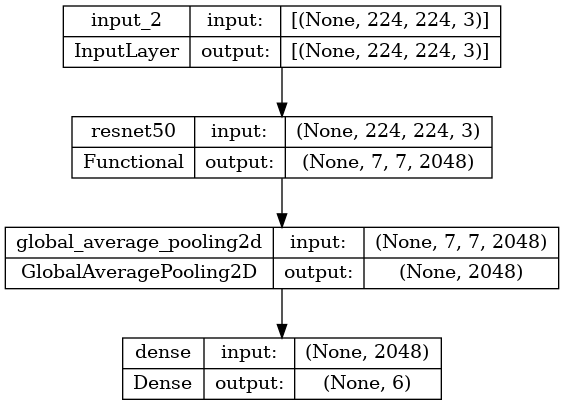

In [25]:
keras.utils.plot_model(model, "ResNet50.png", show_shapes=True)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


### Train the model

In [27]:
'''best_model_checkpoint = ModelCheckpoint(
    filepath= "/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/experiments/fernando/transfer-learning/test01/model",
    monitor='acc',
    save_best_only= True,
    save_weights_only = True
)'''
best_model_checkpoint = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True
)

In [28]:
model = keras.models.load_model('/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/experiments/fernando/transfer-learning/test01/model')

'''training_history = model.fit(
    x = train_data_generator,
    epochs = EPOCHS,
    validation_data = validation_data_generator,
    callbacks=[best_model_checkpoint]
)
model.save(filepath="/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/experiments/fernando/transfer-learning/test01/model")'''

/home/fernandofincatti/.local/lib/python3.10/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/fernandofincatti/.local/lib/python3.10/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100


2022-09-02 11:41:44.226538: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


52/52 [==============================] - 86s 1s/step - loss: 1.5554 - accuracy: 0.4468 - val_loss: 1.1218 - val_accuracy: 0.5707
Epoch 2/100
52/52 [==============================] - 64s 1s/step - loss: 1.1203 - accuracy: 0.5792 - val_loss: 1.1503 - val_accuracy: 0.5707
Epoch 3/100
52/52 [==============================] - 62s 1s/step - loss: 1.0032 - accuracy: 0.6082 - val_loss: 1.0744 - val_accuracy: 0.5870
Epoch 4/100
52/52 [==============================] - 63s 1s/step - loss: 0.9630 - accuracy: 0.6385 - val_loss: 1.0119 - val_accuracy: 0.6196
Epoch 5/100
52/52 [==============================] - 64s 1s/step - loss: 0.9015 - accuracy: 0.6693 - val_loss: 0.9912 - val_accuracy: 0.6685
Epoch 6/100
52/52 [==============================] - 65s 1s/step - loss: 0.8522 - accuracy: 0.6832 - val_loss: 1.0973 - val_accuracy: 0.6304
Epoch 7/100
52/52 [==============================] - 64s 1s/step - loss: 0.8435 - accuracy: 0.6904 - val_loss: 1.1175 - val_accuracy: 0.5707
Epoch 8/100
52/52 [======

INFO:tensorflow:Assets written to: /home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/experiments/fernando/transfer-learning/test01/model/assets


INFO:tensorflow:Assets written to: /home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/experiments/fernando/transfer-learning/test01/model/assets


In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=training_history.history['loss'],mode='lines', name='Training loss'))
fig.add_trace(go.Scatter(y=training_history.history['val_loss'],mode='lines', name='Validation loss'))
fig.add_trace(go.Scatter(y=training_history.history['accuracy'],mode='lines', name='Acc - Training'))
fig.add_trace(go.Scatter(y=training_history.history['val_accuracy'],mode='lines', name='Acc - Validation'))

### Test the model

In [31]:
stratified_test_set["prediction"] = stratified_test_set.apply(
    lambda data: predict_image(model, data["img_id"]), axis=1
)

1/1 [==============================] - 0s 16ms/step


In [32]:
stratified_test_set["prediciton_to_categorical"] = stratified_test_set["prediction"].apply(
    lambda data: probability_to_categorical(data, class_names)
)

In [33]:
stratified_test_set.head()

,index,img_id,diagnostic,prediction,prediciton_to_categorical
0,11,../../../../data/images/all_images/PAT_967_182...,BCC,"[[0.9339105, 0.0419712, 0.0015145763, 0.000171...",BCC
1,719,../../../../data/images/all_images/PAT_905_172...,BCC,"[[0.109780185, 0.37073073, 0.006954382, 0.3313...",ACK
2,305,../../../../data/images/all_images/PAT_1661_29...,ACK,"[[0.740533, 0.10700392, 0.006914731, 0.0240150...",BCC
3,2034,../../../../data/images/all_images/PAT_1107_42...,NEV,"[[0.00010731789, 0.018274218, 0.0005182252, 0....",SEK
4,2098,../../../../data/images/all_images/PAT_2077_44...,ACK,"[[0.8125037, 0.04169358, 0.009618347, 0.004357...",BCC


In [34]:
hit = np.where(
    stratified_test_set['diagnostic']==stratified_test_set['prediciton_to_categorical'],
    1,
    0).sum()
print("Total score = {0}%".format(
    round(hit*100/stratified_test_set.shape[0], 2)
))

Total score = 18.91%


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

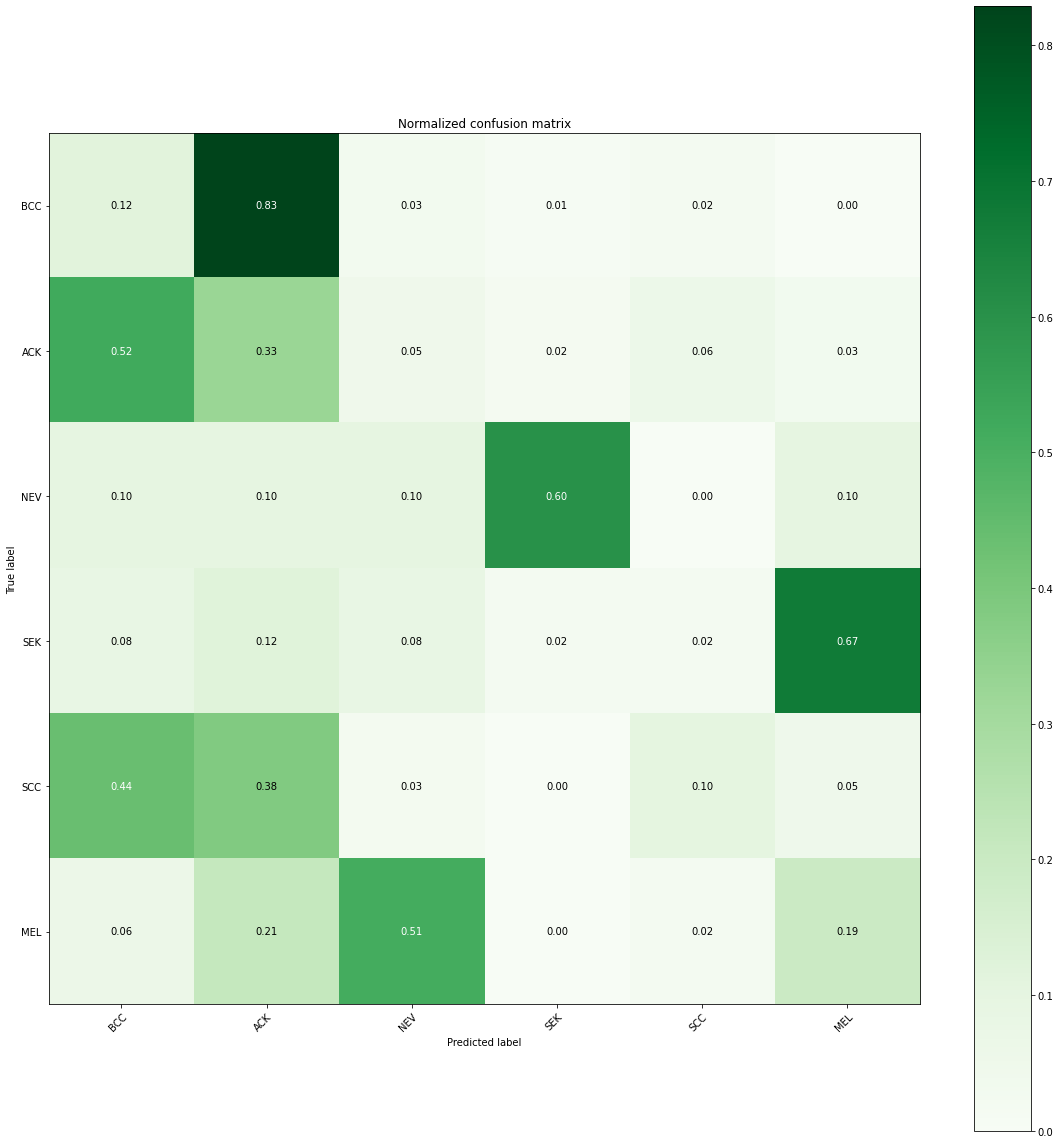

In [35]:
plot_confusion_matrix(
    stratified_test_set["diagnostic"],
    stratified_test_set["prediciton_to_categorical"],
    class_names
    )

In [36]:
stratified_test_set

,index,img_id,diagnostic,prediction,prediciton_to_categorical
0,11,../../../../data/images/all_images/PAT_967_182...,BCC,"[[0.9339105, 0.0419712, 0.0015145763, 0.000171...",BCC
1,719,../../../../data/images/all_images/PAT_905_172...,BCC,"[[0.109780185, 0.37073073, 0.006954382, 0.3313...",ACK
2,305,../../../../data/images/all_images/PAT_1661_29...,ACK,"[[0.740533, 0.10700392, 0.006914731, 0.0240150...",BCC
3,2034,../../../../data/images/all_images/PAT_1107_42...,NEV,"[[0.00010731789, 0.018274218, 0.0005182252, 0....",SEK
4,2098,../../../../data/images/all_images/PAT_2077_44...,ACK,"[[0.8125037, 0.04169358, 0.009618347, 0.004357...",BCC
...,...,...,...,...,...
455,331,../../../../data/images/all_images/PAT_1922_38...,SEK,"[[0.0336431, 0.019023318, 0.009362722, 0.00739...",MEL
456,1747,../../../../data/images/all_images/PAT_1468_36...,ACK,"[[0.6207042, 0.086087614, 0.007834637, 0.02438...",BCC
457,1506,../../../../data/images/all_images/PAT_406_809...,BCC,"[[0.0127484035, 0.62747633, 7.1398434e-05, 0.0...",ACK
458,1093,../../../../data/images/all_images/PAT_1573_24...,ACK,"[[0.64413226, 0.13466048, 0.0072522336, 0.0011...",BCC


In [ ]:
loss, acc = model.evaluate(
    x=x_test,
    y=y_test
)
print("model loss: {0}".format(loss))
print("model accuracy: {0}".format(acc))